In [1]:
# imports
from astropy.io import fits
from scipy import interpolate as sin
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotting as myP
import numpy as np
import csv 
import match
import SED

In [2]:
# path variables 
path_cat = 'D:\IfA REU\Catalogs'
path_fig = 'D:\IfA REU\IfA-REU-Project\Figures'
path_csv = 'D:\IfA REU\IfA-REU-Project\Lists'

# Read CSV

In [3]:
# read from a given csv file and return a list of its contents 
def ReadFile(filename) : 
    # initialize list
    file = []
    # open csv file
    with open(filename, newline='') as csv_file : 
        reader = csv.reader(csv_file, delimiter=',', quotechar='"')
        # output file into list for easy access
        for row in reader :
            file.append(row)
    # print column names 
    print(filename, '\tcolumns: ', file[0])
    # return an array of type int with column names clipped off
    return(file[1:])

In [4]:
# read AGN ID and index from csv files
agn_irSel20 = np.array(ReadFile(path_csv+'\Match_COSMOS2020_IRAGN_to_COSMOS2020.csv'), dtype=int)
zMatch      = np.array(ReadFile(path_cat+'\COSMOS_z_matches.csv'))

D:\IfA REU\IfA-REU-Project\Lists\Match_COSMOS2020_IRAGN_to_COSMOS2020.csv 	columns:  ['ID', 'i']
D:\IfA REU\Catalogs\COSMOS_z_matches.csv 	columns:  ['ID', 'z']


In [5]:
# transpose arrays to get columns
agn_irSel20_id, agn_irSel20_i = agn_irSel20.T
zMatch_id, zMatch_z = zMatch.T

# get correct data type
zMatch_id = np.array(zMatch_id, dtype=int)
zMatch_z  = np.array(zMatch_z,  dtype=float)

# Get Data From Catalog 

In [6]:
# open COSMOS 2020 catalog file and get data 
inf20 = fits.open(path_cat+'\COSMOS2020_CLASSIC_R1_v2.0_master.fits')
data20 = inf20[1].data
cols20 = inf20[1].columns
inf20.close()

In [7]:
# print(cols20)

In [8]:
flux_nu_uJy = SED.GetPhotometry(data20)
ids = SED.GetID(data20)
lam_A = SED.GetObservedWavelengths_A()

Array shape (1720700, 20)
Array shape (1720700,)


# Refine Data

In [9]:
# get mask of valid redshifts
mask_z = (zMatch_z >= 0) & (zMatch_z < 99)

# apply mask to remove -99 redshifts
zValid_id = zMatch_id[mask_z]
zValid_z  = zMatch_z[mask_z]

# print info
print('number of sources in z matches:\t',  len(zMatch_id))
print('Number of sources with z:\t',        len(zValid_id))

number of sources in z matches:	 865086
Number of sources with z:	 485793


In [10]:
# match redshifts to agn
key_z, key_agn = match.match(zValid_id, agn_irSel20_id)

# apply key to get parallel lists if agn-z matches
z_id    = zValid_id[key_z]
z_z     = zValid_z[key_z]
agn_id  = agn_irSel20_id[key_agn]
agn_i   = agn_irSel20_i[key_agn]

# get flux table of agn sources 
agn_flux_nu_uJy = flux_nu_uJy[agn_i]

# print info
print('Number of Donley Sources:\t', len(agn_irSel20_id))
print('Number of Donley sources w/ z:\t', len(agn_id))

Number of Donley Sources:	 1533
Number of Donley sources w/ z:	 1533


In [11]:
# get table of rest wavelengths
lamR_A = SED.ConvertToRestWavelength(z_z)

Array shape (1533, 20)


# Convert Units

In [12]:
# convert wavelength units
lamR_um = lamR_A * 1E-4
lam_um  = lam_A  * 1E-4

In [13]:
# convert Fnu to lamFlam
agn_lamflux_lam_ergscm2 = SED.ConvertToEnergyDensity(lamR_A, agn_flux_nu_uJy)

Array shape (1533, 20)


# Make SED

In [14]:
# normalize each agn source
agn_lamflux_lam_ergscm2_NORM = SED.NormalizeSED_1um(lamR_A, agn_lamflux_lam_ergscm2)

Array shape (1533, 20)


In [15]:
# set standard plot format
myP.SetStyle()

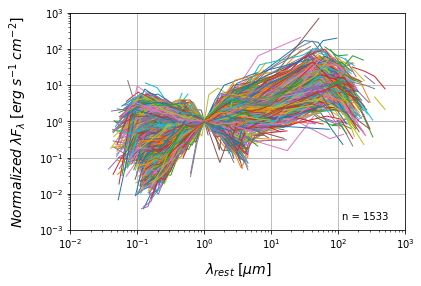

In [16]:
# plot some sources 
x = lamR_um
y = agn_lamflux_lam_ergscm2_NORM
r,c = np.shape(x)
SED.PlotSED(x,y,num=r, save=path_fig+'\COSMOS2020_SED_irAGN_all.png')

# Sort SED by Redshift 

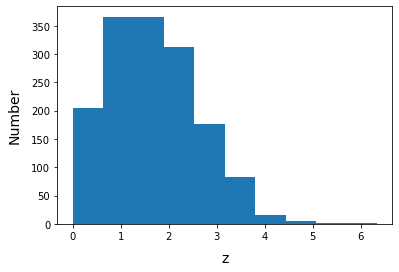

min:  0.0
max:  6.3381


In [17]:
plt.hist(z_z)
plt.xlabel('z')
plt.ylabel('Number')
plt.show()

print('min: ', min(z_z))
print('max: ', max(z_z))

In [18]:
# # define masks for redshift bins
# bin_z = np.array([
#     (z_z > 0.0) & (z_z <= 0.5), (z_z > 0.5) & (z_z <= 1.0), (z_z > 1.0) & (z_z <= 1.5), 
#     (z_z > 1.5) & (z_z <= 2.0), (z_z > 2.0) & (z_z <= 2.5), (z_z > 2.5) & (z_z <= 3.0), 
#     (z_z > 3.0) & (z_z <= 3.5), (z_z > 3.5) & (z_z <= 4.0), (z_z > 4.0)
# ])

# # TODO make 0-1 bin (only this bin for paper for now)

# # titles of redshift bins
# bin_z_title = np.array(['0.0-0.5', '0.5-1.0', '1.0-1.5', '1.5-2.0', '2.0-2.5', '2.5-3.0', '3.0-3.5', '3.5-4.0', '>4.0'])

In [19]:
# define masks for redshift bins
bin_z = np.array([
    (z_z > 0.0) & (z_z <= 1.0), 
    (z_z > 1.0) & (z_z <= 2.0), 
    (z_z > 2.0), 
    
])

# titles of redshift bins
bin_z_title = np.array(['0.0-1.0', '1.0-2.0', '2.0-6.5'])

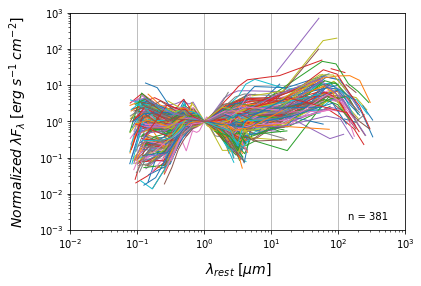

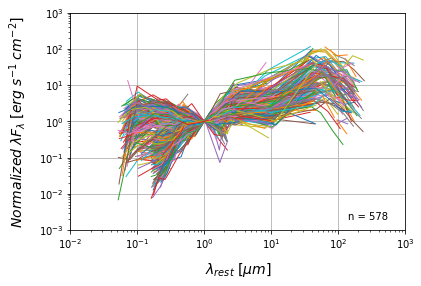

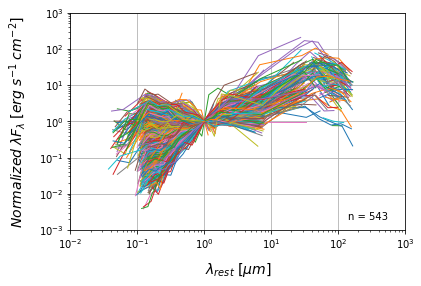

In [20]:
# plot SED for each bin 
for i,z in enumerate(bin_z) :
    x = lamR_um[z]
    y = agn_lamflux_lam_ergscm2_NORM[z]
    r,c = np.shape(x)
    # t = bin_z_title[i]
    saveStr = path_fig+'\COSMOS2020_SED_irAGN_'+bin_z_title[i]+'.png'
    SED.PlotSED(x,y,r,save=saveStr)